In [174]:
from Autograder_Util import load_ref_dataset
from Autograder_Util import load_character_data

ref_file = "graphics.txt"
user_file = "你_Points.csv"
user_data, char_list = load_character_data(user_file)
ref_data = load_ref_dataset(ref_file, char_list)

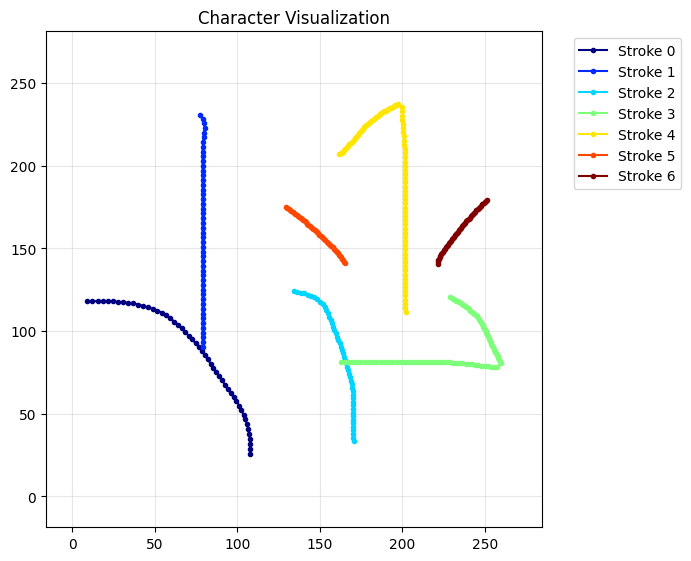

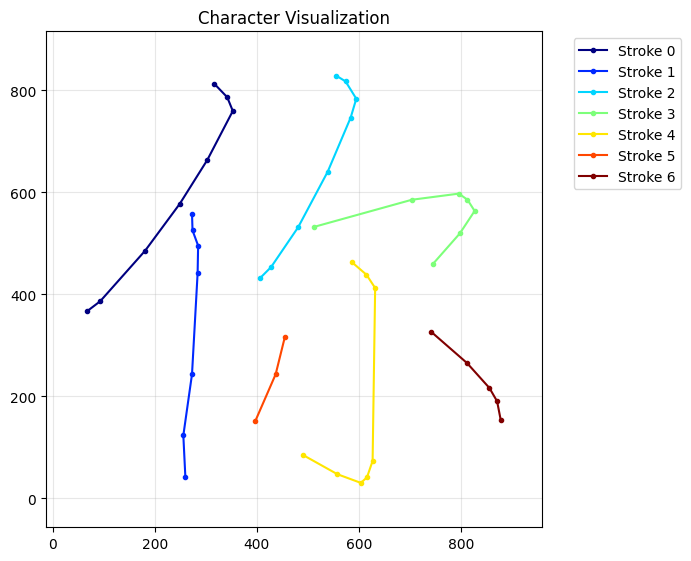

In [175]:
from Autograder_Util import plot_character
plot_character(user_data[0], flip = False)
plot_character(ref_data[0], flip = False)



In [194]:
from scipy.spatial.distance import cdist
import numpy as np
from scipy.spatial.distance import cdist

def compute_principal_angle(stroke):
    centered = stroke - np.mean(stroke, axis=0)
    _, _, vh = np.linalg.svd(centered, full_matrices=False)
    return np.arctan2(vh[0, 1], vh[0, 0])

def rotate_stroke(stroke, angle_rad):
    center = np.mean(stroke, axis=0)
    centered = stroke - center

    c, s = np.cos(angle_rad), np.sin(angle_rad)
    R = np.array([[c, -s], [s, c]])
    rotated = centered @ R.T
    return rotated + center


def angle_align(stroke, ref_stroke, max_rotation = 20):
    rad = np.deg2rad(max_rotation)

    angle_stroke = compute_principal_angle(stroke)
    angle_ref = compute_principal_angle(ref_stroke)
    
    angle_diff = angle_ref - angle_stroke
    
    angle_diff = (angle_diff + np.pi) % (2 * np.pi) - np.pi
    
    angle_diff = np.clip(angle_diff, -rad, rad)
    
    return rotate_stroke(stroke, angle_diff)


def normalize(stroke):

    stroke = np.asarray(stroke)

    min_xy = stroke.min(axis=0)
    max_xy = stroke.max(axis=0)

    size = max_xy - min_xy
    max_dim = np.max(size)

    if max_dim == 0:
        return np.full_like(stroke, 0.5)

    # Scale relative to largest dimension
    scaled = (stroke - min_xy) / max_dim

    # Compute current center
    scaled_min = scaled.min(axis=0)
    scaled_max = scaled.max(axis=0)
    scaled_center = (scaled_min + scaled_max) / 2

    # Shift to center at (0.5, 0.5)
    shift = np.array([0.5, 0.5]) - scaled_center
    centered = scaled + shift

    return centered


def compute_stroke_dtw(char_data, true_char, num_pts=50):
    s1 = char_data
    s2 = true_char
    
    s1 = angle_align(s1, s2)

    s1 = normalize(s1)
    s2 = normalize(s2)

    n, m = len(s1), len(s2)
    cost = cdist(s1, s2, metric='euclidean')

    dtw = np.full((n+1, m+1), np.inf)
    dtw[0, 0] = 0

    for i in range(1, n+1):
        for j in range(1, m+1):
            dtw[i, j] = cost[i-1, j-1] + min(
                dtw[i-1, j],
                dtw[i, j-1],
                dtw[i-1, j-1]
            )

    return dtw[n, m]

def compute_char_dtw(char_data, true_char, num_pts=50, threshold = 7, index_penalty = 0.5):
    plot_character(char_data, flip = False)
    plot_character(true_char, flip = False)
    result = []
    for i in range(len(char_data)):
        min_cost = 1000
        match_index = None
        for j in range(len(char_data)):
            cost = compute_stroke_dtw(char_data[i], true_char[j], num_pts) + index_penalty * abs(i - j) # Bias towards assigning corresponding strokes
            if(min_cost > cost): 
                min_cost = cost
                match_index = (i, j)
        if(min_cost >= threshold): result.append(0)
        elif(match_index[0] == match_index[1]): result.append(1)
        else: result.append(2)
    return result


In [195]:

# input: list of user characters, true characters, and labels
# user_chars - list of chars, each char is a list of strokes
# true_chars - list of chars, each char is a list of strokes
# labels - contains labels for each stroke in each character, contains 0 for incorrect, 1 for correct, 2 for correct but wrong order 

# user_chars & true_chars exists in R(n, s)
# labels ~ exists in R(n, s)
# n ~ number of characters, s ~ number of strokes

def compute_accuracy(user_chars, ref_chars, labels, comparison_function):
    if(len(user_chars) != len(ref_chars) or len(user_chars) != len(labels)):
        print("length mismatch")
        return
    else:
        user_chars = preprocess_characters(user_chars, num_pts=50, target_scale=1.0, flip_y=True)
        ref_chars = preprocess_characters(ref_chars, num_pts=50, target_scale=1.0, flip_y=False)
        data_len = len(user_chars)
        accuracies = []
        for i in range(data_len):
            results = comparison_function(user_chars[i], ref_chars[i]) # results has length s
            print(results)
            accuracy = np.mean(np.array(results) == np.array(labels[i]))
            print("accuracy", accuracy)
            accuracies.append(accuracy)
        return np.mean(accuracies)

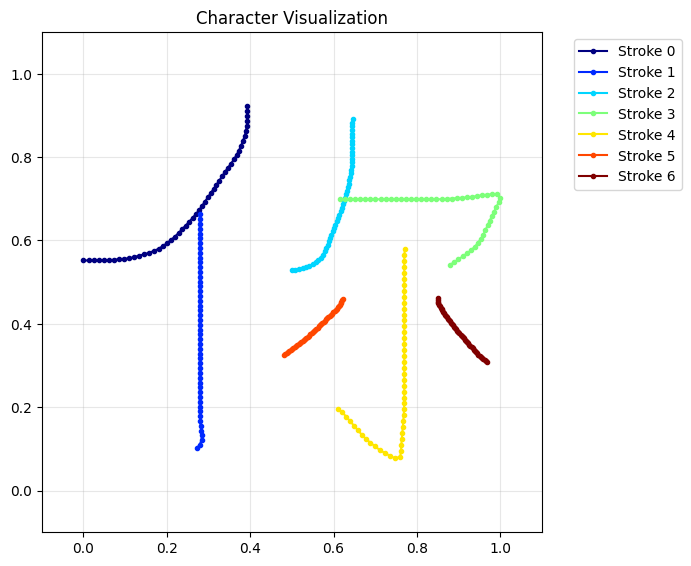

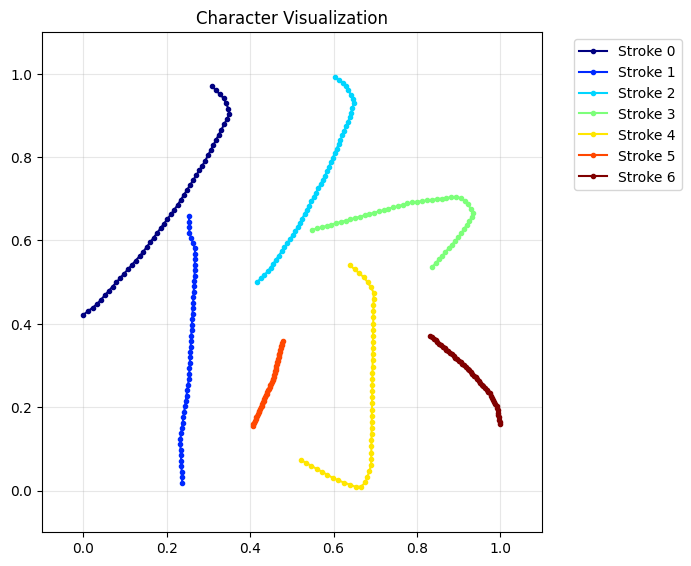

4.687592895691391
9.731458680168817
5.25086149032214
23.721019488823075
6.782633850591355
8.677476258404386
22.229459020094303
(0, 0)
5.169237130825103
0.4868710568781323
3.3479498941062373
17.893805772396924
8.623451288292564
2.901573429200808
9.634955114479533
(1, 1)
4.486673608935032
3.6957255996870995
3.3629477047270213
19.032882070088867
4.4991918115795
6.07460196399963
12.827734543125631
(2, 2)
20.87162723444316
15.715325898862883
18.12430670526528
1.2926962698234576
14.672470868730494
18.11995756779423
9.044501805063769
(3, 3)
6.355109656070476
8.384494115800155
5.388385990525785
20.490247814437225
1.3023689263540692
6.602219503984097
12.233385056873747
(4, 4)
4.1941296791018505
7.914415090179124
3.0831441736627476
24.885149506194523
7.936828263547845
1.9029183369952936
18.532101251174037
(5, 5)
16.652886153664415
8.04682517075226
13.288055825094709
14.513222058597236
12.162389741508054
9.907088809467336
6.233900292947969
(6, 6)
[1, 1, 1, 1, 1, 1, 1]
accuracy 1.0
1.0


In [196]:
labels = [[1, 1, 1, 1, 1, 1, 1]]
result = compute_accuracy(user_data, ref_data, labels, compute_char_dtw)
print(result)

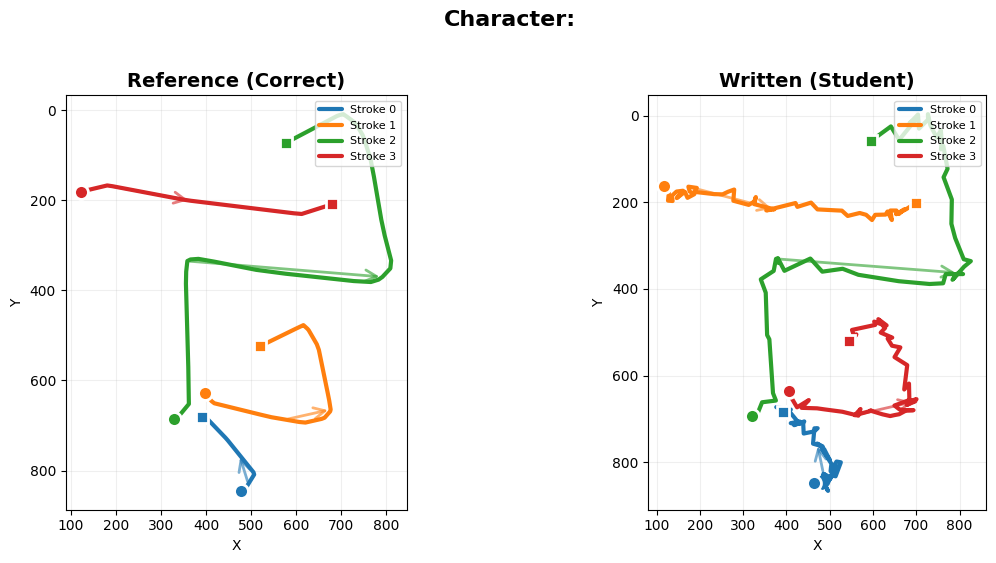

Matching 4 written strokes to 4 reference strokes
  Normalized to [0, 100] range
  Extracted features (center, length, angle, etc.)
  Running GA with population=32, max_gen=100
  Converged in 18 generations
  Best fitness: 0.0047
  Detected 6 errors


In [1]:
from stroke_matcher import StrokeMatcher
from test_stroke_matcher_realistic import (
    load_character_from_graphics,
    add_motor_noise,
    inject_order_error
)
from plot_utils import plot_comparison
import matplotlib.pyplot as plt


file_path = "graphics.txt"
char_name, reference = load_character_from_graphics(file_path, 100)

written = add_motor_noise(reference, position_noise=10)

written, description = inject_order_error(written, n_swaps=1)

fig = plot_comparison(reference, written, f"Character:")
plt.show()

matcher = StrokeMatcher()
result = matcher.match(written, reference, verbose=True)

